# TP5

## Constantes et modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from util import readAngles, readSinogram, saveImage
### TOUT REMETTRE DANS RECONSTRUCTION À LA FIN ###
from reconstruction_copie import readInput, laminogram, backproject, backproject_interpol
from CTfiltre import filterSinogram
import math

## Question 1

Dans un but de reconstruction tomographique, on peut modéliser l'atténuation du rayonnement qui passe à travers un objet par la loi de Beer-Lambert:
$$I = I_0e^{-\int\mu(x)\text{d}x}$$
Sous forme discrétisée, on a:
$$I = I_0e^{-\sum\mu(x)\Delta x}$$
où $I$  est l'intensité détectée, $I_0$ est l'intensité initiale, $\mu$ est le coefficient d'atténuation linéaire et $x$ est la distance traversée par les rayons. Sous forme linéaire, on a:
$$\ln\bigg(\frac{I_0}{I}\bigg) = \sum\mu(x)\Delta x$$
Pour simplifier le problème, on peut considérer le corps humain comme étant composé d'eau pure. On peut alors déterminer la fraction du signal qui traverse le corps humain en utilisant le coefficient $\mu$ de l'eau. Selon les données XCOM du NIST [1], En considérant des photons ayant une énergie initiale de 60 keV, l'atténuation dans l'eau est de $2,059\times10^{-1}\ \text{cm}^2/g$. Pour une masse volumique de $1\ \text{g/cm}^3$, on obtient le paramètre $\mu(x)$ suivant:
$$\mu(x) = 2,059\times10^{-1}\ \text{cm}^2/g \times 1\ \text{g/cm}^3 = 2,059\times10^{-1}\ \text{cm}^{-1}$$
On peut alors déterminer la fraction du signal qui va être mesurée après avoir parcouru une distance donnée dans l'eau. Pour une distance de 5 cm, on a
$$\frac{I}{I_0} = e^{-\int \mu(x)\\text{d}x}$$
$$\frac{I}{I_0} = e^{-\int_0^5 2,059\times10^{-1}\text{d}x}$$
$$\frac{I}{I_0} = 0,3572$$
On observera donc 35,8 % de l'intensité du faisceau incident pour une distance de 5 cm dans l'eau (ou le corps humain). Pour une distance de 20 cm, on a:
$$\frac{I}{I_0} = e^{-\int_0^20 2,059\times10^{-1}\text{d}x}$$
$$\frac{I}{I_0} = 0,0163$$
On mesurera donc 1,63 % de l'intensité du faisceau initial pour une distance de 20 cm parcourue dans l'eau.

$$\textcolor{red}{\text{VÉRIFIER LES RÉPONSES AVEC D'AUTRES GROS CERVOS}}$$

## Question 2

On veut maintenant développer une méthode de reconstruction toomographique afin de pouvoir reconstruire des images de tomodensitométrie. Le fichier *sinogram-patient.txt* correspond au sinogramme d'une image de tomodensitométrie qu'on souhaite reconstruire. Le fichier *sinogram-password.txt* contient le sinogramme d'un mot de passe qui permet d'accéder à l'image contenue dans *sinogram-patient.txt*, fournie à des fins de comparaisons avec les résultats obtenus.

Pour effectuer la reconstruction, on utilise la rétroprojection, qui consiste à *étaler* chaque pixel de chaque projection sur la trajectoire dont il mesure l'absorption. On utilise ensuite une approche *voxel-driven* pour déterminer, pour chaque voxel, la contribution de chaque projection sur le voxel. On doit donc calculer, pour chaque orientation, quelle trajectoire passe le plus près du voxel d'intérêt. Pour ce faire, il est pratique d'exprimer la position de chaque pixel en coordonnées polaires avec l'origine au centre de l'image. On obtient alors la situation représentée à la figure 1. La quantité qui nous intéresse ici est la distance $d$ pour chaque projection avec une orientation $\theta$, car celle-ci nous renseigne sur la position du pixel qui mesure l'absorption du voxel. Un fois que nous connaissons la position du bon pixel, on peut simplement additionner la valeur de celui-ci au voxel. On répéte ensuite l'opération pour chaque orientation et éventuellement pour chaque voxel afin de recréer l'image.

<center><img src="Situation_Q2.png" style="width: 400px;"/></center>
<center>Figure 1. Reconstruction par méthode voxel-driven

La reconstruction par rétroprojection est implémentée dans la fonction *laminogram* du fichier *reconstruction.py*. Les constantes utilisées par la méthode, comme la taille et le nombre des pixels et des voxels, ainsi que les noms des fichiers de données sont définis dans le fichier *geometry.py*. Des méthodes générales utilisées dans *reconstruction.py* sont définies dans le fichier *util.py*.

La fonction *laminogram* ne prend aucun argument, mais utilise les données fournies par *readInput*, une fonction définie dans *reconstruction.py* qui extrait les données à partir des fichiers de données en format *.txt*. Elle effectue ensuite le processus itératif de l'approche *voxel-driven*. Tout d'abord, la position du voxel d'intérêt en coordonnées cartésiennes est déterminée à partir des indices de celui-ci et des constantes définies dans *geometry.py*. On effectue ensuite le changement de coordonnées afin d'avoir la position du pixel en coordonnées polaires. On détermine ensuite la distance $d$ à partir de la position en coordonnées polaires et de l'orientation de la projection. En arrondissant, on obtient l'indice correspondant au bon pixel. On additionne sa valeur au voxel et on répète le processus pour toutes les projections. En répétant ce processus pour tous les voxels, on obtient la reconstruction tomographique du sinogramme.

La reconstruction du sinogramme du mot de passe correspond à *mdp_laminogram.png* et on voit que le mot de passe est *Z8HA9*. On effectue ensuite la reconstruction de l'image médicale.

In [2]:
laminogram()

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]
working on image column: 1/96
working on image column: 2/96
working on image column: 3/96


KeyboardInterrupt: 

L'image médicale reconstruite est enregistrée comme *patient_laminogram.png*. On peut maintenant comparer la reconstruction avec l'image de référence présentée à la figure 2.

<center><img src="patient_ref.png" style="width: 220px;"/></center>
<center>Figure 2. Image de référence du sinogramme du patient

Le constraste de l'image reconstruite n'est pas aussi bon que celui de l'image de référence. Sur la reconstruction, une sorte de flou lumineux qui empêche de bien distinguer les éléments présents. Les contours sont beaucoup mieux définis et beaucoup plus faciles à observer sur l'image de référence. Certaines structures, comme les petits corps blancs autour de ce qui semble être les poumons, ne peuvent pas être observées sur la reconstruction. La différence entre les tons de gris des différentes parties de l'image est également moins prononcée sur la reconstruction, ce qui nuit aussi à la qualité de l'image.

## Question 3

On veut maintenant améliorer la reconstruction du sinogramme. Pour ce faire, on peut appliquer un filtre passe-haut sur le sinogramme afin de tenter d'éliminer le "flou lumineux", qui est principalement contenu dans les basses fréquences. Comme filtre passe-haut, on choisit simplement de multiplier la transformée de Fourier du sinogramme par $|u|$, où $u$ correspond à la variable dépendante dans l'espace des fréquences. Le filtre va donc bel et bien favoriser les hautes fréquentes, où $u$ est grand, et défavoriser les basses fréquences, où $u$ est petit.

On crée alors les fonctions *filterLine* et *filterSinogram* dans le fichier *CTfiltre.py*. La fonction *filterLine* prend en argument une projection contenue dans une ligne du sinogramme et et retourne celle-ci avec le filtre passe-haut appliqué. Pour ce faire, elle effectue d'abord la tranformée de Fourier de la projection à l'aide de la fonction *numpy.fft.fft*, détermine les valeurs discrétisées de $u$ associées à la transformée de Fourier grâce à la fonction *numpy.fft.fftfreq*, multiplie la transformée de Fourier par $|u|$ puis retourne la transformée de Fourier inverse de la projection avec *numpy.fft.ifft*. La fonction *filterSinogram* prend en entrée un sinogramme et applique le filtre sur toutes ses projections en utilisant *filterLine*. Elle retourne le sinogramme résultant.

On affiche et sauvegarde l'image du sinogramme non-filtré du patient comme *sino_non-filtre.png* et celle du sinogramme filtré du patient comme *sino_filtre.png*.

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


c:\Users\benja\OneDrive\Documents\ULaval\Physique numérique\Git_repository\PhysNum\TP5\CTfiltre.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  sinogram[i] = filterLine(sinogram[i])


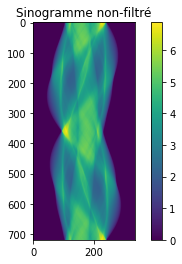

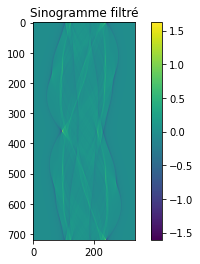

In [9]:
# on récupère le sinogramme du patient
sino = readInput()[2]

# on affiche et sauvegarde le sinogramme non-filté
fig1 = plt.figure()
plt.title("Sinogramme non-filtré")
plt.imshow(sino)
plt.colorbar()
plt.savefig("sino_non-filtre.png")

# on filtre le sinogramme
filterSinogram(sino)

# on affiche et sauvegarde le sinogramme filtré
fig2 = plt.figure()
plt.title("Sinogramme filtré")
plt.imshow(sino)
plt.colorbar()
plt.savefig("sino_filtre.png")

Le sinogramme non-filtré comporte des valeurs srtictement positives où le 0 signifie une atténuation nulle. Sur le sinogramme filtré, on observe plutôt un fond à 0 partout avec les constrastes positifs ou négatifs qui ressortent. C'est ce à quoi on s'attendait, car les contrastes et les détails sont stockés dans les petites fréquences, tandis que les valeurs générales des zones sont stockées dans les basses fréquences. C'est aussi prometteur pour notre reconstruction, car on souhaite pouvoir mieux observer les détails sur l'image reconstruite.

## Question 4

On utilise maintenant les fonctions contenues dans *CTfiltre.py* pour créer la fonction *backproject*, située dans *reconstruction.py*. Celle-ci fonctionne exactement comme la fonction *laminogram*, mais, avant d'effectuer le processus itératif, elle applique le filtre passe-haut déterminé à la question 3 grâce à la fonction *filterSinogram*.

On peut ensuite reconstruire les deux sinogrammes. La reconstruction du mot de passe est enregistrée comme *mdp_backproject.png* et celle du patient est enregistrée comme *patient_backproject.png*.

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


c:\Users\benja\OneDrive\Documents\ULaval\Physique numérique\Git_repository\PhysNum\TP5\CTfiltre.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  sinogram[i] = filterLine(sinogram[i])


working on image column: 1/96
working on image column: 2/96
working on image column: 3/96
working on image column: 4/96
working on image column: 5/96
working on image column: 6/96
working on image column: 7/96
working on image column: 8/96
working on image column: 9/96
working on image column: 10/96
working on image column: 11/96
working on image column: 12/96
working on image column: 13/96
working on image column: 14/96
working on image column: 15/96
working on image column: 16/96
working on image column: 17/96
working on image column: 18/96
working on image column: 19/96
working on image column: 20/96
working on image column: 21/96
working on image column: 22/96
working on image column: 23/96
working on image column: 24/96
working on image column: 25/96
working on image column: 26/96
working on image column: 27/96
working on image column: 28/96
working on image column: 29/96
working on image column: 30/96
working on image column: 31/96
working on image column: 32/96
working on image 

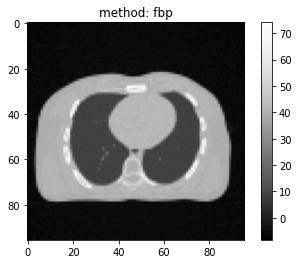

In [ ]:
backproject()

En comparant avec le fantôme numérique, on observe que la reconstruction filtrée est de bien meilleure qualité que la reconstruction non filtrée. Par contre, il reste tout de même des erreurs semblables à du bruit, donc de très hautes fréquences. Ces erreurs sont facilement observables dans la région noire de l'image, qui est d'un noir plus uni sur le fantôme numérique que sur la reconstruction. Pour référence future, on note que le temps d'exécution de la cellule de code qui exécute la fonction *backproject* comporte un temps d'exécution de 2 minutes et 4,1 secondes.

## Question 5

Toujours dans le but d'améliorer la qualité de la reconstruction, on peut remplacer la méthode du plus proche voisin, qui consistait à prendre la valeur du pixel dont la trajectoire passe le plus près du centre du voxel, par une interpolation linéaire des deux trajectoires qui passent le plus près du centre du voxel. Pour ce faire, on crée, dans *geometry.py*, la fonction *interpol_lin*. Celle-ci prend en argument les valeurs d'atténuation des 2 pixels dont les trajectoires sont les plus près du centre du voxel et la distance entre le rayon 1, qui est celui des deux situé entre le voxel et l'origine, et le centre du voxel. La fonction calcule le taux de variation spatial entre les rayons 1 et 2 et multiplie cette valeur par la distance entre le rayon 1 et le centre du voxel afin d'obtenir la valeur d'atténuation à ajouter au voxel.

Dans *reconstruction.py*, on crée ensuite la fonction *backproject_interpol*, qui effectue la reconstruction de l'image en utilisant les valeurs d'atténuation déterminées par interpolation linéaire. Le fonctionnement est essentiellement le même que dans *backproject*, sauf que les valeurs de distances entre le rayon passant par le centre de l'image et le centre du voxel sont arrondies à la hausse et à la baisse afin d'obtenir les deux rayons les plus près. Le rayon le plus près de l'origine est alors identifié comme étant le rayon 1 et l'autre comme étant le rayon 2. Les valeurs d'atténuation sont ensuites déterminées à l'aide de la fonction *interpol_lin*.

On reconstruit l'image du patient avec notre nouvelle fonction et on enregistre le résultat comme *patient_interpol.png*.

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


c:\Users\benja\OneDrive\Documents\ULaval\Physique numérique\Git_repository\PhysNum\TP5\CTfiltre.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  sinogram[i] = filterLine(sinogram[i])


working on image column: 1/96
working on image column: 2/96
working on image column: 3/96
working on image column: 4/96
working on image column: 5/96
working on image column: 6/96
working on image column: 7/96
working on image column: 8/96
working on image column: 9/96
working on image column: 10/96
working on image column: 11/96
working on image column: 12/96
working on image column: 13/96
working on image column: 14/96
working on image column: 15/96
working on image column: 16/96
working on image column: 17/96
working on image column: 18/96
working on image column: 19/96
working on image column: 20/96
working on image column: 21/96
working on image column: 22/96
working on image column: 23/96
working on image column: 24/96
working on image column: 25/96
working on image column: 26/96
working on image column: 27/96
working on image column: 28/96
working on image column: 29/96
working on image column: 30/96
working on image column: 31/96
working on image column: 32/96
working on image 

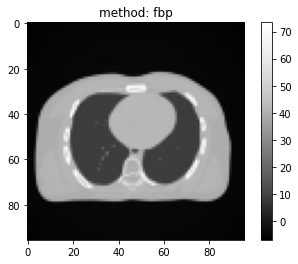

In [2]:
backproject_interpol()

On remarque que les erreurs de hautes fréquences, semblables à du bruit, qui étaient présentes sur les précédentes reconstruction sont absentes ici. L a détermination des valeurs d'atténuation par interpolation linéaire a donc permis une amélioration significative de la qualité de la reconstruction. Selon l'indicateur de la cellule de code, le temps de reconstruction est de 1 minute et 23,1 secondes. Surprenamment, le temps d'exécution est significativement plus court que dans le cas sans interpolation linéaire. Cela est probablement dû à l'utilisation de la fonction *numpy.round* pour arrondir les distances dans le cas sans interpolation, ce qui prend plus de temps d'exécution que les fonctions *math.ceil* et *math.floor* utilisées pour arrondir à la hausse et à la baisse dans le cas avec interpolation.